In [6]:
# replace pracs csv load with SQL

# Set dates of baseline and follow-up periods
d5 = '2019-03-01' # month after end of follow-up period
d4 = '2019-09-01' # follow-up start
d3 = '2019-04-01' # month after end of baseline period
d2 = '2019-01-01' # start of 3-month baseline period
d1 = '2018-04-01' # start of 12-month baseline period


# first set up table to query
'''SELECT * FROM 
`ebmdatalab.hscic.normalised_prescribing_standard` 
WHERE SUBSTR(bnf_code,1,9) = '0206020M0'
AND EXTRACT(year FROM month) > 2017 '''

#### save as helen.nimodipine_20190513

# import data for all practices prescribing nimodipine, 
# excluding those which are dormant/closed,
# excluding practices which are not standard general practices
# excluding practices in Devon CCG (or one of its predecessor organisations NEW Devon CCG)

# Import dataset from BigQuery
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT  
    a.practice,
    a.pct,
    setting,
    a.month,
    total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM helen.nimodipine_20190513 a
   INNER JOIN hscic.practices b ON a.practice = b.code AND setting=4 
   INNER JOIN `hscic.practice_statistics_all_years` pop  ON a.practice = pop.practice AND a.month = pop.month and status_code = "A"
WHERE pct NOT IN ('99P','15N')
    AND pop.total_list_size > 1000 
    AND (male_25_34 + male_35_44 + male_45_54 + male_55_64 + female_25_34 + female_35_44 + female_45_54 + female_55_64)
    / total_list_size BETWEEN 0.1 and 0.85
GROUP BY practice, pct, setting, month, total_list_size
'''
df1 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

        ## note: parsing dates is quite memory-intensive, make sure not too many programmes running

df1["month"] = pd.to_datetime(df1.month)

df1.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,pct,setting,month,total_list_size,items,quantity
0,M88002,05L,4,2018-08-01 00:00:00+00:00,8947,1,60
1,G82032,09J,4,2018-03-01 00:00:00+00:00,13884,1,22
2,C87015,03L,4,2018-12-01 00:00:00+00:00,7008,1,112
3,E85712,07W,4,2018-04-01 00:00:00+00:00,7129,1,100
4,H81029,09N,4,2018-03-01 00:00:00+00:00,11800,1,100


In [25]:
### classify data by baseline period
import datetime

d3 = '2019-03-01' # month after end of baseline period
d2 = '2018-12-01' # start of 3-month baseline period
d1 = '2018-03-01' # start of 12-month baseline period

df1["12-mo-baseline"] = False
df1["3-mo-baseline"] = False
df1.loc[(df1['month']>=d1)&(df1['month']<d3), "12-mo-baseline"] = True
df1.loc[(df1['month']>=d2)&(df1['month']<d3), "3-mo-baseline"] = True

df1.head(20)

,practice,pct,setting,month,total_list_size,items,quantity,12-mo-baseline,3-mo-baseline
0,M88002,05L,4,2018-08-01 00:00:00+00:00,8947,1,60,True,False
1,G82032,09J,4,2018-03-01 00:00:00+00:00,13884,1,22,True,False
2,C87015,03L,4,2018-12-01 00:00:00+00:00,7008,1,112,True,True
3,E85712,07W,4,2018-04-01 00:00:00+00:00,7129,1,100,True,False
4,H81029,09N,4,2018-03-01 00:00:00+00:00,11800,1,100,True,False
5,B86081,15F,4,2019-02-01 00:00:00+00:00,14386,1,84,True,True
6,E81036,06F,4,2019-01-01 00:00:00+00:00,13146,1,152,True,True
7,N81624,02F,4,2019-02-01 00:00:00+00:00,8230,1,112,True,True
8,H81029,09N,4,2019-02-01 00:00:00+00:00,11423,1,100,True,True
9,M83691,05G,4,2018-11-01 00:00:00+00:00,1912,1,100,True,False


In [77]:
### aggregate data over 6-month periods ( we will want to calculate the change between each)

# Perform groupby aggregation
agg = df1.loc[df1["12-mo-baseline"]==True].groupby(["practice","3-mo-baseline"])["items","quantity"].sum().reset_index()
#agg_3m = df1.groupby(["practice"])["items","quantity"].sum().reset_index()


# any prescribing in last 3 months
filter1 = agg.loc[agg["3-mo-baseline"]==True][["practice"]]

agg = agg.merge(filter1, on="practice", how="inner").groupby(["practice","3-mo-baseline"]).sum()
agg = pd.DataFrame(agg.stack()).unstack(1)
agg.columns = agg.columns.droplevel()

agg["12-mo"] = agg[True] + agg[False]
agg = agg.reset_index().rename(columns={True:"3-mo","level_1":"prescribing"}).drop(False, axis=1).fillna(0).set_index(["practice","prescribing"]).unstack()

# More than one item of nimodipine prescribed OR more than 56 tablets prescribed in the latest 12 months#
agg = agg.loc[(agg["12-mo","items"]>1) | (agg["12-mo","quantity"]>56)]#.sort_values(by="quantity")
agg

3-mo-baseline  3-mo          12-mo         
prescribing   items quantity items quantity
practice                                   
A82036          2.0     90.0  11.0    594.0
A83047          5.0   1120.0  13.0   2812.0
B86081          3.0    252.0  11.0    924.0
C81110          1.0    224.0   6.0   1344.0
C82027          1.0     28.0   8.0    224.0
C82051          4.0    224.0  12.0    672.0
C86007          2.0    336.0  11.0   1848.0
D82008          2.0     84.0  14.0    578.0
D82042          3.0    220.0  14.0   1538.0
D82067          1.0     60.0   2.0    160.0
E82074         13.0    546.0  60.0   2520.0
E84709          6.0    672.0  11.0   1232.0
E85074          1.0     84.0   5.0   1092.0
E86018         11.0    616.0  51.0   2856.0
F84062          8.0    168.0  48.0   1008.0
F84708          1.0     28.0   2.0     56.0
G82050          3.0    180.0  13.0    780.0
G83065          2.0    168.0   5.0    420.0
G84004          3.0     84.0  13.0    308.0
G85112          3.0    600.0  14.0   2118.0
H81029          1.0    100.0   5.0    500.0
H81035          2.0    120.0  11.0    660.0
H83611          1.0    100.0   4.0    400.0
J82083          1.0    168.0   6.0   1008.0
J82144          3.0    900.0   4.0   1000.0
J83036          1.0     28.0   4.0    112.0
J83633          2.0    110.0   7.0    370.0
K81060          1.0    100.0   4.0    400.0
L81054          4.0    224.0  44.0   2464.0
L81669          2.0    240.0  11.0   1320.0
M83051          4.0    200.0   5.0    300.0
M83691          3.0    300.0  11.0   1100.0
M84004          2.0    336.0   7.0   1176.0
M85046          1.0    300.0   7.0   2100.0
M85079          1.0     60.0   4.0    240.0
M86004          1.0     28.0   5.0    140.0
M88002          2.0    336.0  18.0   2160.0
M88026          1.0     60.0   2.0    120.0
M92007          1.0    100.0   5.0    500.0
N81624          2.0    224.0   6.0    672.0
P81020          4.0    448.0  10.0   1120.0
P81655          3.0    168.0  12.0    672.0
P81730          2.0    180.0   9.0    810.0
P84034          1.0     56.0   3.0    196.0
Y02885          2.0    672.0   7.0   2072.0

In [43]:
### create histogram chart to demonstrate outlier status.

q = '''SELECT  
    pop.practice as practice,
    b.ccg_id as pct,
    setting,
    pop.month,
    total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM `hscic.practice_statistics_all_years` pop 
   INNER JOIN hscic.practices b  ON b.code = pop.practice AND status_code = "A"
   LEFT JOIN helen.nimodipine_20190513 a ON a.practice = pop.practice AND a.month = pop.month
WHERE 
    pop.month>'2018-11-01' and
    setting=4 AND
    pop.total_list_size > 1000 
    AND (male_25_34 + male_35_44 + male_45_54 + male_55_64 + female_25_34 + female_35_44 + female_45_54 + female_55_64)
    / total_list_size BETWEEN 0.1 and 0.85
GROUP BY practice, pct, setting, month, total_list_size
'''
df2 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

df2["month"] = pd.to_datetime(df1.month)

df2.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,pct,setting,month,total_list_size,items,quantity
0,E83018,07M,4,2018-08-01 00:00:00+00:00,16270,NaN,NaN
1,J82075,11A,4,2018-03-01 00:00:00+00:00,6927,NaN,NaN
2,G84005,07Q,4,2018-12-01 00:00:00+00:00,5189,NaN,NaN
3,N81624,02F,4,2018-04-01 00:00:00+00:00,8230,1.0,112.0
4,C82010,03W,4,2018-03-01 00:00:00+00:00,16138,NaN,NaN


In [50]:
df3 = df2.copy() 
data = df3.groupby("practice").sum().reset_index()
data.head()

,practice,setting,total_list_size,items,quantity
0,A81001,12,12256,0.0,0.0
1,A81002,12,58804,0.0,0.0
2,A81004,12,31889,0.0,0.0
3,A81005,12,24156,0.0,0.0
4,A81006,12,43777,0.0,0.0


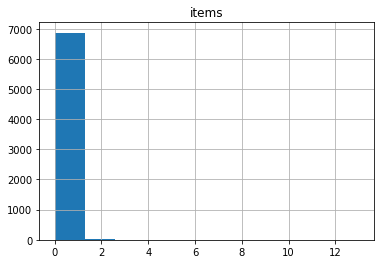

In [51]:
import matplotlib.pyplot as plt

data[["practice","items"]].hist()

plt.show()

In [12]:
df7.to_csv('practice_allocations.csv') 